# Experimento 4 :Creación de un segmentador semantico.Arquitectura pix2pix.



## Librerías usadas.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Parámetros globales

In [ ]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))
checkpoints = os.path.dirname(os.path.realpath("../TFG/Pix2PixCheckpoints/..."))


csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 64
longitud = 64
clases = 7


print(data_dir)

print(csv_path)



/home/antoniojesus/Escritorio/TFG/Datos
/home/antoniojesus/Escritorio/TFG/Datos/HAM10000_metadata.csv


In [ ]:
 
data_dir_mascara_binaria = os.path.dirname(os.path.realpath("../TFG/DatosMascaraBinaria/..."))
data_dir_mascara_superpuesta = os.path.dirname(os.path.realpath("../TFG/DatosMascaraSuperpuesta/..."))
print(data_dir_mascara_binaria +"    "+ data_dir_mascara_superpuesta)

/home/antoniojesus/Escritorio/TFG/DatosMascaraBinaria    /home/antoniojesus/Escritorio/TFG/DatosMascaraSuperpuesta


## Creación del marco de datos.

In [ ]:
def combineData(data_dir):
    all_image_path = glob(os.path.join(data_dir, '*', '*'))
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
    return imageid_path_dict




#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

data_dict = combineData(data_dir)
data_dict_mask = combineData(data_dir_mascara_binaria)
data_dict_rgb_mask = combineData(data_dir_mascara_superpuesta)

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(data_dict.get)
dataFrame['mask_path'] = dataFrame['image_id'].map(data_dict_mask.get)
#dataFrame['rgb_mask_path'] = dataFrame['image_id'].map(data_dict_rgb_mask.get)

dataFrame = dataFrame.drop('dx', 1)
dataFrame = dataFrame.drop('dx_type', 1)
dataFrame = dataFrame.drop('age', 1)
dataFrame = dataFrame.drop('sex', 1)
dataFrame = dataFrame.drop('localization', 1)

dataFrame.head()


,lesion_id,image_id,path,mask_path
0,HAM_0000118,ISIC_0027419,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,/home/antoniojesus/Escritorio/TFG/DatosMascara...
1,HAM_0000118,ISIC_0025030,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,/home/antoniojesus/Escritorio/TFG/DatosMascara...
2,HAM_0002730,ISIC_0026769,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,/home/antoniojesus/Escritorio/TFG/DatosMascara...
3,HAM_0002730,ISIC_0025661,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,/home/antoniojesus/Escritorio/TFG/DatosMascara...
4,HAM_0001466,ISIC_0031633,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,/home/antoniojesus/Escritorio/TFG/DatosMascara...


In [ ]:
def prepro(l):
    nl = []
    for i in tqdm(range(len(l))):
        splits = randurls[i].split("/")
        fileN = splits[-2]+"/"+splits[-1]
        nl.append(fileN)
    return nl

n = 500                         #Número de muestras a tomar
train_n = round(n*0.80)         #Separación de set de datos y entrenamiento
imgurls = dataFrame['path']
randurls = np.copy(imgurls)

np.random.seed(23)              #Sirve para que la aleatoriedad seaa siempre la misma
np.random.shuffle(randurls)
randurls = prepro(randurls)
#Partición train/test
tr_urls = randurls[:train_n]
ts_urls =randurls[train_n:n]

print(len(imgurls), len(tr_urls),len(ts_urls))

100%|██████████| 10015/10015 [00:00<00:00, 384448.12it/s]

10015 400 100


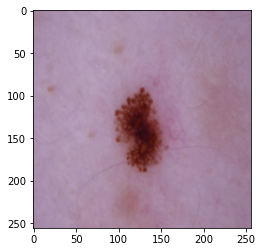

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(inimg,tgimg,height,width):
    #resize : reescala las imagenes en función a los parametros height y width. 
    #Retorna las imágenes reescaladas

    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])
    
    return inimg,tgimg

def normalize(inimg,tgimg):
    #normalize : normaliza las imagenes al rango [-1 , +1 ] (indicado en el paper)
    #Retorna las imágenes normalizadas
    
    inimg = (inimg/127.5) - 1
    tgimg = (tgimg/127.5) - 1
    
    return inimg,tgimg

def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)
    
    stacked_image = tf.stack([inimg,tgimg],axis=0)
    cropped_image = tf.image.random_crop(stacked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
    
    inimg,tgimg = cropped_image[0],cropped_image[1]
    
    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)
    return inimg,tgimg

def load_image(filename,augment = True):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(data_dir + "/"+filename)),tf.float32)[...,:3]
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(data_dir_mascara_binaria + "/"+filename)),tf.float32)[...,:3]
    

    tgimg = tf.image.grayscale_to_rgb(tgimg)
 
    inimg , tgimg = resize(inimg,tgimg,IMG_WIDTH,IMG_HEIGHT)
    
    if augment:
        inimg , tgimg = random_jitter(inimg,tgimg)
    
    inimg , tgimg = normalize(inimg,tgimg)
    
    return inimg,tgimg

def load_train_image(filename):
    return load_image(filename,True)

def load_test_image(filename):
    return load_image(filename,False)

plt.imshow(((load_train_image(randurls[1])[0])+1)/2)


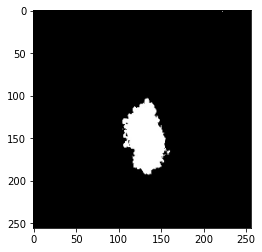

In [ ]:
plt.imshow(((load_test_image(randurls[1])[1])+1)/2)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image)
train_dataset = train_dataset.batch(1)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(1)

# El siguiente paso será generar la arquitectura pix2pix.

El modelo pix2pix es una red generativa adversaria condicionada, que en su parte generadora esta formada por una U-net a modo de autoencoder con multiples skipconnection.El discriminador es una patchGAN(existen otros como PixelGan o ImageGan)

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

#Bloque convolucional para las capas del encoder.

def downsample(filters,apply_batchnorm = True):
    
    result = Sequential()
    
    #Inicializado, le indicamos que queremos 0.02 de ruido Gaussiano. Indicado en el paper
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    #Capa de convolución parametrizada según el paper
    
    result.add(Conv2D(filters,
                     kernel_size = 4,
                     strides=2,
                     padding="same",
                     kernel_initializer=initializer,
                     use_bias = not apply_batchnorm)) #Bias es una parámetro de sesgo que no es importante si la red convolucional va precedida de una capa de bachnormalization
    
    if(apply_batchnorm):
        result.add(BatchNormalization())
    
    result.add(LeakyReLU())
    
    return result


In [ ]:
#Bloque convolucional para las capas del decoder.

def upsample(filters,apply_dropout = True):
    
    result = Sequential()
    
    #Inicializado, le indicamos que queremos 0.02 de ruido Gaussiano. Indicado en el paper
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    #Capa de convolución inversa parametrizada según el paper
    
    result.add(Conv2DTranspose(filters,
                         kernel_size = 4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         use_bias = False)) #Bias es una parámetro de sesgo que no es importante si la red convolucional va precedida de una capa de bachnormalization
    
    result.add(BatchNormalization())
    
    if apply_dropout:
        result.add(Dropout(0.5))
    
    result.add(ReLU()) #IMPORTANTE, es diferente a la función de activación de los bloques de downsampling
    
    return result


In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[None,None,3]) #El shape del input es [None,None,3] para que así podamos introducir cualquier imágen.
    
    down_stack = [                    #Shape de los tensores.
        
        downsample(64,False),         #(bs,128,128,64)
        downsample(128),              #(bs,64,64,128)
        downsample(256),              #(bs,32,32,256)
        downsample(512),              #(bs,16,16,512)
        downsample(512),              #(bs,8,8,512)
        downsample(512),              #(bs,4,4,512)
        downsample(512),              #(bs,2,2,512)
        downsample(512)               #(bs,1,1,512)      
    ]
    
    up_stack = [
        upsample(512,True),           #(bs,2,2,1024)
        upsample(512,True),           #(bs,4,4,1024)
        upsample(512,True),           #(bs,8,8,1024)
        upsample(512),                #(bs,16,16,1024)
        upsample(256),                #(bs,32,32,512)
        upsample(128),                #(bs,64,64,256)
        upsample(64)                  #(bs,128,128,128)

    ]
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    last = Conv2DTranspose(filters = 3,                         #Numero de filtros = número de canales de la imágen generada
                          kernel_size = 4,
                          strides=2,
                          padding="same",
                          kernel_initializer=initializer,
                          activation = "tanh")                  #Las imágenes estarían en el rango de -1 a 1 luego la función que mejor se ajusta es la tangente hiperbolica
                          
        
#Conectamos las capas del codificador      
        
    x = inputs    
    s = []
    concat = Concatenate()
    
    for down in down_stack:
        
        x = down(x)
        s.append(x)
        
    s = reversed(s[:-1])
#Conectamos las capas del decodificador   

    for up,sk in zip(up_stack,s):
        
        x = up(x)
        x = concat([x,sk])
        
    
    last = last(x)
    
    return Model(inputs=inputs,outputs=last)

generador = Generator()

In [ ]:
def Discriminator():

    ini = Input(shape=[None,None,3], name = "input_img")
    gen = Input(shape=[None,None,3], name = "gener_img")
    
    con = concatenate([ini,gen])
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    down1 = downsample(64,False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)
    
    last = Conv2D(filters = 1,
                kernel_size = 4,
                strides=1,
                padding="same",
                kernel_initializer=initializer)(down4)
    
    return tf.keras.Model(inputs=[ini,gen],outputs=last)

discriminator = Discriminator()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True) #from_logits fuerza a que los valores se acoten al dominio de 0 y 1,
                                                                     # siendo lo mismo que aplicar una función sigmoide como dicen en el paper.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    # real_loss, computa el resultado de comparar una imagen real con
    # la imágen generada con una matriz de bits a 1(esta matriz sería el resultado perfecto)
    # mediante el objeto loss_object
    
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output) 
    
    
    # generated_loss, computa el resultado de comparar una imagen real con
    # la imágen generada con una matriz de bits a 0(esta matriz sería el resultado perfecto para el discriminado)
    # mediante el objeto loss_object
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
LAMBDA = 100


def generator_loss(disc_generated_output, gen_output, target):
    
    #La función generator_loss va a tener dos objetivos, conseguir una imagen realista, 
    #y puesto que es una GAN, aumentar el error del discriminador. 
    
    
    # gan_loss,evalua si en generador engaña o no al discriminador. 
    # Es donde se establece la componente adversaria del sistema.
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    


    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss) #Lamda es un parametro ponderativo del error, 
                                                   #se dejará tal y como se especifica en paper

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                 discriminator_optimizer=discriminator_optimizer,
#                                 generator=generator,
#                                 discriminator=discriminator)
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [ ]:
PATH = ""
def generate_images(model,test_input,tar,save_filename=False,display_imgs=True):
    
    prediction = model(test_input,training=True)
    
    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH+"output"+save_filename+".jpg",prediction[0,...])
        
    plt.figure(figsize=(10,10))
    
    display_list = [test_input[0],tar[0],prediction[0]]
    title= ["Input Image","Ground Truth","Predicted Image"]
    
    if display_imgs:
        for i in range(3):
            plt.subplot(1,3,i+1)
            plt.title(title[i])
            plt.imshow(display_list[i]*0.5+0.5)
            plt.axis("off")
            
    plt.show()

In [ ]:
@tf.function()
def train_step(input_image,target):
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as discr_tape: #Fundamental para realizar el backpropagation
    
        output_image = generador(input_image,training=True)
    
        output_gen_discr = discriminator([output_image,input_image],training=True)
    
        output_trg_discr = discriminator([target,input_image],training=True)
    
        discr_loss = discriminator_loss(output_trg_discr,output_gen_discr)
    
        gen_loss = generator_loss(output_gen_discr,output_image,target)
    
    
        #Tomamos el valor de los gradientes
    
        generator_grads = gen_tape.gradient(gen_loss,generador.trainable_variables)
        
        discriminator_grads = discr_tape.gradient(discr_loss,discriminator.trainable_variables)
        
        
        #Aplicamos los gradientes
        
        generator_optimizer.apply_gradients(zip(generator_grads,generador.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))
    

In [ ]:
from IPython.display import clear_output

def train(dataset,epochs):
    for epoch in range(epochs):
        
        imgi=0
        for input_image,target in dataset:
            print("epoch "+ str(epoch)+" - train: " + str(imgi)+"/" + str(len(tr_urls)))
            imgi+=1
            train_step(input_image,target)
            clear_output(wait=True)
            
        for inp, tar in test_dataset.take(5):
            generate_images(generador,inp,tar,str(imgi)+"_"+str(epoch),display_imgs=True)
        
#        if(epoch + 1) % 25 == 0:
#            checkpoint.save(file_prefix = checkpoint_prefix)

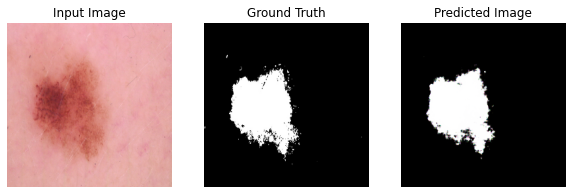

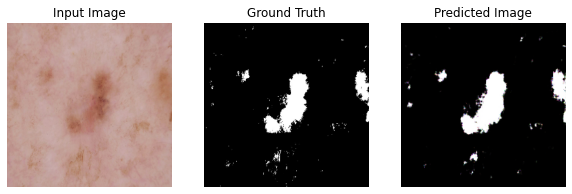

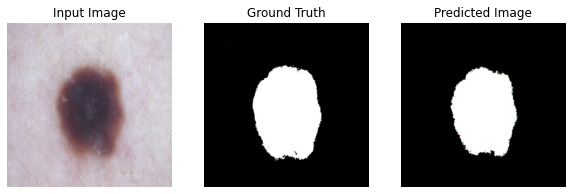

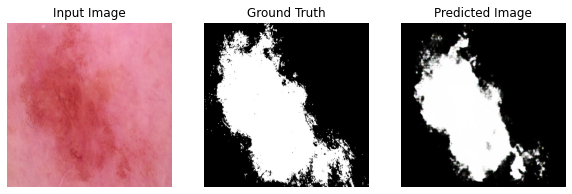

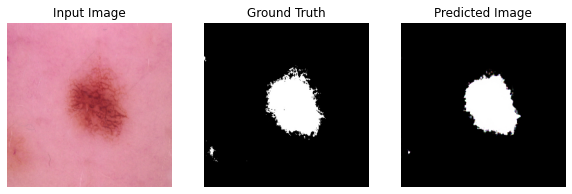

In [ ]:
train(train_dataset,1)